### Google Drive setup

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.366243
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$

$f(x_i; W) =  W x_i$

Since initial $W_j \approx 0$, it follows that $f_j \approx 0$, therefore

$$L = -\log \frac{e^{f_{y_i}}}{\sum_{j=0}^{C-1} e^{f_j}} \approx -\log \frac{e^0}{\sum_{j=0}^{C-1} e^0} = -\log \frac{1}{C} = \log C$$

where $C$ is the total number of classes.

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.350448 analytic: -0.350448, relative error: 2.657268e-08
numerical: -1.216147 analytic: -1.216147, relative error: 4.376003e-09
numerical: -0.637600 analytic: -0.637600, relative error: 3.991602e-08
numerical: 2.641045 analytic: 2.641045, relative error: 1.929742e-08
numerical: 3.391305 analytic: 3.391305, relative error: 2.617591e-10
numerical: -2.073814 analytic: -2.073815, relative error: 3.222983e-08
numerical: 1.678430 analytic: 1.678430, relative error: 1.139013e-08
numerical: 2.064429 analytic: 2.064429, relative error: 1.768319e-08
numerical: 0.356027 analytic: 0.356027, relative error: 5.854007e-08
numerical: -2.126551 analytic: -2.126551, relative error: 6.443563e-10
numerical: 0.092976 analytic: 0.092976, relative error: 1.476376e-07
numerical: -0.403939 analytic: -0.403939, relative error: 1.067359e-07
numerical: -3.313148 analytic: -3.313148, relative error: 1.402173e-08
numerical: 0.367220 analytic: 0.367220, relative error: 1.920413e-08
numerical: -2.536370

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.366243e+00 computed in 0.099999s
vectorized loss: 2.366243e+00 computed in 0.010017s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from cs231n.classifiers import Softmax
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, batch_size=200, verbose=True)
        y_train_pred = softmax.predict(X_train)
        tr_acc = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (tr_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 21.366167 learning rate 0.000000 regularization 500.000000
iteration 100 / 1500: loss 20.775926 learning rate 0.000000 regularization 500.000000
iteration 200 / 1500: loss 20.343800 learning rate 0.000000 regularization 500.000000
iteration 300 / 1500: loss 19.750855 learning rate 0.000000 regularization 500.000000
iteration 400 / 1500: loss 19.676940 learning rate 0.000000 regularization 500.000000
iteration 500 / 1500: loss 19.710108 learning rate 0.000000 regularization 500.000000
iteration 600 / 1500: loss 19.694890 learning rate 0.000000 regularization 500.000000
iteration 700 / 1500: loss 19.076489 learning rate 0.000000 regularization 500.000000
iteration 800 / 1500: loss 18.704285 learning rate 0.000000 regularization 500.000000
iteration 900 / 1500: loss 19.022028 learning rate 0.000000 regularization 500.000000
iteration 1000 / 1500: loss 18.915992 learning rate 0.000000 regularization 500.000000
iteration 1100 / 1500: loss 18.395645 learning rate 0.0

C:\Users\Roman\Repositories\cs321n\assignment1\cs231n\classifiers\softmax.py:85: RuntimeWarning: divide by zero encountered in log
  loss -= np.mean(np.log(target_scores))


iteration 100 / 1500: loss inf learning rate 0.000005 regularization 500000.000000
iteration 200 / 1500: loss inf learning rate 0.000005 regularization 500000.000000


C:\Users\Roman\Repositories\cs321n\assignment1\cs231n\classifiers\softmax.py:91: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(np.diagonal(W.T.dot(W)))
C:\Users\Roman\.venv\cs231n\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


iteration 300 / 1500: loss inf learning rate 0.000005 regularization 500000.000000
iteration 400 / 1500: loss inf learning rate 0.000005 regularization 500000.000000
iteration 500 / 1500: loss inf learning rate 0.000005 regularization 500000.000000


C:\Users\Roman\Repositories\cs321n\assignment1\cs231n\classifiers\softmax.py:92: RuntimeWarning: overflow encountered in multiply
  dW += reg*2*W
C:\Users\Roman\Repositories\cs321n\assignment1\cs231n\classifiers\softmax.py:79: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores, axis=1).reshape(-1,1)


iteration 600 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
iteration 700 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
iteration 800 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
iteration 900 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
iteration 1000 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
iteration 1100 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
iteration 1200 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
iteration 1300 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
iteration 1400 / 1500: loss nan learning rate 0.000005 regularization 500000.000000
lr 1.000000e-08 reg 5.000000e+02 train accuracy: 0.155429 val accuracy: 0.148000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.133429 val accuracy: 0.127000
lr 1.000000e-08 reg 5.000000e+03 train accuracy: 0.157673 val accuracy: 0.152000
lr 1.

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.389000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$

True

$\color{blue}{\textit Your Explanation:}$

If the weights are pre-trained such that the score of the target label for the new data point is above the threshold value, this data point will not change the overall loss, because per-datapoint loss will be zero:

$$L_i^\text{Hinge} = \sum_{j\neq y_i} \max(0, w_j^T x_i - w_{y_i}^T x_i + \Delta)$$

On the other hand, softmax loss is defined in a way such that any new data point will change the loss function because softmax wants to improve loss for any score, no matter how high or close to the target the prediction is:

$$L_i^\text{Softmax} = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in}$$

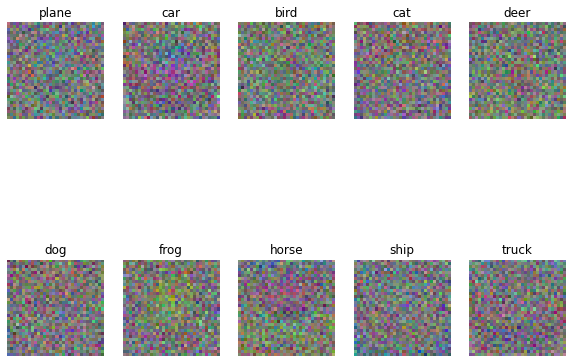

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])